### Imports


In [ ]:
# Import from src/ and config/
from src.preprocessing import preprocess_aachen_dataset
from config.defaults import Config

# Load the default configuration
config = Config()

# Preprocess the dataset for regression (LSTM)
preprocess_aachen_dataset(config)

# Preprocess the dataset for classification (CNN)
config.classification = True 
preprocess_aachen_dataset(config)


## LSTM

### Data Load

In [2]:
from src.models import load_preprocessed_data

model_task = "lstm_regression"

# Load preprocessed data
X_train, X_val, X_test, y_train, y_val, y_test, metadata = load_preprocessed_data(
    model_task, config.eol_capacity
)

2025-03-05 13:22:57,827 - INFO - Loaded preprocessed data and metadata for lstm_regression with EOL 0.65


### Grid Search

In [15]:
from src.grid_search import run_hyperparameter_search

run_hyperparameter_search(config, model_task)

2025-03-05 13:11:31,470 - INFO - Running hyperparameter search for: lstm_regression
2025-03-05 13:11:31,471 - INFO - Loading preprocessed data for hyperparameter tuning with lstm_regression...
2025-03-05 13:11:31,488 - INFO - Loaded preprocessed data and metadata for lstm_regression with EOL 0.65
2025-03-05 13:11:31,514 - INFO - Starting hyperparameter tuning...
2025-03-05 13:11:31,518 - INFO - Best hyperparameters found: {'lstm_units': 32, 'lstm_dropout_rate': 0.30000000000000004, 'lstm_dense_units': 56, 'learning_rate': 0.01, 'clipnorm': 1.0}
2025-03-05 13:11:31,521 - INFO - Best hyperparameters saved to: experiments/hyperparameter_tuning/Experiment1_lstm_regression_tuning_eol65_best_params.json


Reloading Tuner from experiments/hyperparameter_tuning/Experiment1_lstm_regression_tuning_eol65/tuner0.json


{'lstm_units': 32,
 'lstm_dropout_rate': 0.30000000000000004,
 'lstm_dense_units': 56,
 'learning_rate': 0.01,
 'clipnorm': 1.0}

### Train model

In [3]:
from src.models import train_lstm_model

# Update the configuration
config.load_best_params(model_task)

# Input shape for the CNN model
input_shape = (config.seq_len, 1)

lstm_model, history = train_lstm_model(config, X_train, y_train, X_val, y_val, input_shape)

2025-03-05 13:22:58,650 - INFO - LSTM model built with tuned config: Config(project_name='Experiment1', data_path='data/raw/Degradation_Prediction_Dataset_ISEA.mat', eol_capacity=0.65, test_cell_count=3, random_state=42, log_transform=False, classification=False, seq_len=120, train_split_ratio=0.8, val_split_ratio=0.2, batch_size=32, max_trials=5, tuning_epochs=10, tuner_directory='experiments/hyperparameter_tuning', conv1_filters=32, conv1_kernel_size=11, conv2_filters=64, conv2_kernel_size=7, conv3_filters=64, conv3_kernel_size=5, l2_reg=0.001, cnn_dense_units=64, cnn_dropout_rate=0.2)


Loaded best hyperparameters from experiments/hyperparameter_tuning/Experiment1_lstm_regression_tuning_eol65_best_params.json: {'lstm_units': 32, 'lstm_dropout_rate': 0.30000000000000004, 'lstm_dense_units': 56, 'learning_rate': 0.01, 'clipnorm': 1.0}
Epoch 1/50
140/142 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197 - mae: 0.0999
Epoch 1: val_loss improved from inf to 0.03175, saving model to experiments/models/lstm_regression_eol65_20250305_132258_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0195 - mae: 0.0994 - val_loss: 0.0318 - val_mae: 0.1439
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106 - mae: 0.0726
Epoch 2: val_loss improved from 0.03175 to 0.00681, saving model to experiments/models/lstm_regression_eol65_20250305_132258_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0106 - mae: 0.0725 - val_loss: 0.0068 - val_mae: 0.0679
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054 - mae: 0.0570
Epoch 3: val_loss d

2025-03-05 13:24:19,230 - INFO - Final LSTM model saved to experiments/models/lstm_regression_eol65_20250305_132419_final.keras


## CNN

### Data Load

In [1]:
from src.models import load_preprocessed_data
from config.defaults import Config

# Load the default configuration
config = Config()

model_task = "cnn_classification"

# Load preprocessed data
X_train, X_val, X_test, y_train, y_val, y_test, metadata = load_preprocessed_data(
    model_task, config.eol_capacity
)

2025-03-05 13:37:55,073 - INFO - Loaded preprocessed data and metadata for cnn_classification with EOL 0.65


### Grid Search

In [19]:
from src.grid_search import run_hyperparameter_search

run_hyperparameter_search(config, model_task)

2025-03-05 13:13:10,960 - INFO - Running hyperparameter search for: cnn_classification
2025-03-05 13:13:10,963 - INFO - Loading preprocessed data for hyperparameter tuning with cnn_classification...
2025-03-05 13:13:10,967 - INFO - Loaded preprocessed data and metadata for cnn_classification with EOL 0.65
2025-03-05 13:13:10,987 - INFO - Starting hyperparameter tuning...
2025-03-05 13:13:10,989 - INFO - Best hyperparameters found: {'conv1_filters': 32, 'conv1_kernel_size': 9, 'l2_reg': 0.0005, 'conv2_filters': 64, 'conv2_kernel_size': 9, 'conv3_filters': 64, 'conv3_kernel_size': 3, 'cnn_dense_units': 192, 'cnn_dropout_rate': 0.4, 'learning_rate': 0.0001}
2025-03-05 13:13:10,992 - INFO - Best hyperparameters saved to: experiments/hyperparameter_tuning/Experiment1_cnn_classification_tuning_eol65_best_params.json


Reloading Tuner from experiments/hyperparameter_tuning/Experiment1_cnn_classification_tuning_eol65/tuner0.json


{'conv1_filters': 32,
 'conv1_kernel_size': 9,
 'l2_reg': 0.0005,
 'conv2_filters': 64,
 'conv2_kernel_size': 9,
 'conv3_filters': 64,
 'conv3_kernel_size': 3,
 'cnn_dense_units': 192,
 'cnn_dropout_rate': 0.4,
 'learning_rate': 0.0001}

### Train model

In [2]:
from src.models import train_cnn_model

# Update the configuration
config.load_best_params(model_task)

# Input shape for the CNN model
input_shape = (config.seq_len, 1)

cnn_model, history = train_cnn_model(config, X_train, y_train, X_val, y_val, input_shape)

2025-03-05 13:37:55,194 - INFO - CNN model built with tuned config: Config(project_name='Experiment1', data_path='data/raw/Degradation_Prediction_Dataset_ISEA.mat', eol_capacity=0.65, test_cell_count=3, random_state=42, log_transform=False, classification=False, seq_len=120, train_split_ratio=0.8, val_split_ratio=0.2, batch_size=32, max_trials=5, tuning_epochs=10, tuner_directory='experiments/hyperparameter_tuning', conv1_filters=32, conv1_kernel_size=9, conv2_filters=64, conv2_kernel_size=9, conv3_filters=64, conv3_kernel_size=3, l2_reg=0.0005, cnn_dense_units=192, cnn_dropout_rate=0.4)


Loaded best hyperparameters from experiments/hyperparameter_tuning/Experiment1_cnn_classification_tuning_eol65_best_params.json: {'conv1_filters': 32, 'conv1_kernel_size': 9, 'l2_reg': 0.0005, 'conv2_filters': 64, 'conv2_kernel_size': 9, 'conv3_filters': 64, 'conv3_kernel_size': 3, 'cnn_dense_units': 192, 'cnn_dropout_rate': 0.4, 'learning_rate': 0.0001}
Epoch 1/50
135/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3816 - loss: 1.8114
Epoch 1: val_loss improved from inf to 2.21721, saving model to experiments/models/cnn_classification_eol65_20250305_133755_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3865 - loss: 1.7943 - val_accuracy: 0.1506 - val_loss: 2.2172
Epoch 2/50
133/142 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5480 - loss: 1.2439
Epoch 2: val_loss did not improve from 2.21721
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5493 - loss: 1.2412 - val_accuracy: 0.1745 - val_loss: 2.2985
Epoch 3/50
139/142 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - a

2025-03-05 13:38:37,170 - INFO - Final CNN model saved to experiments/models/cnn_classification_eol65_20250305_133837_final.keras


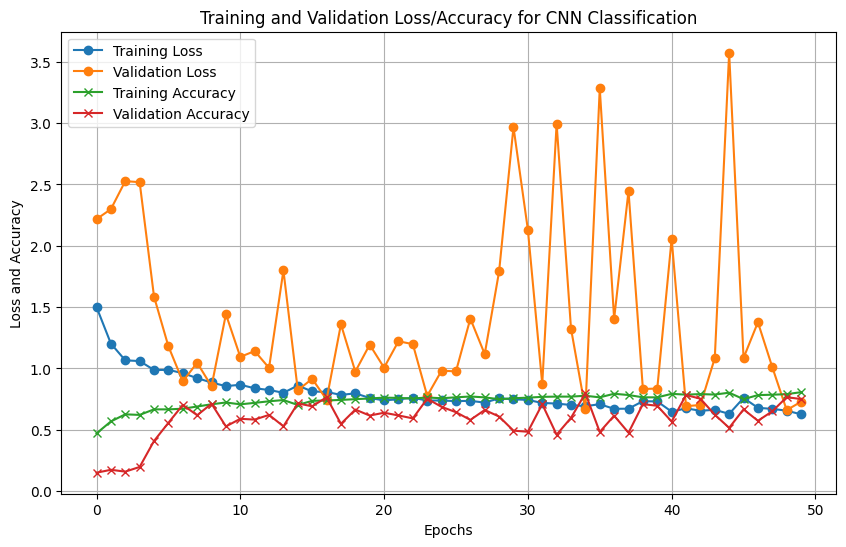

In [3]:
from src.utils import plot_training_history

# Plot the training history for the LSTM model
plot_training_history(history, model_task)

In [4]:
# Test of the load saved model function
from src.models import load_saved_model

cnn_model = load_saved_model(model_task, config.eol_capacity, config)

2025-03-05 13:38:37,452 - INFO - Loaded saved best CNN model from experiments/models/cnn_classification_eol65_20250305_133755_best.keras


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6746 - loss: 0.7923  


2025-03-05 13:38:37,893 - INFO - Test Loss (Crossentropy): 0.7382
2025-03-05 13:38:37,894 - INFO - Test Accuracy: 0.7136


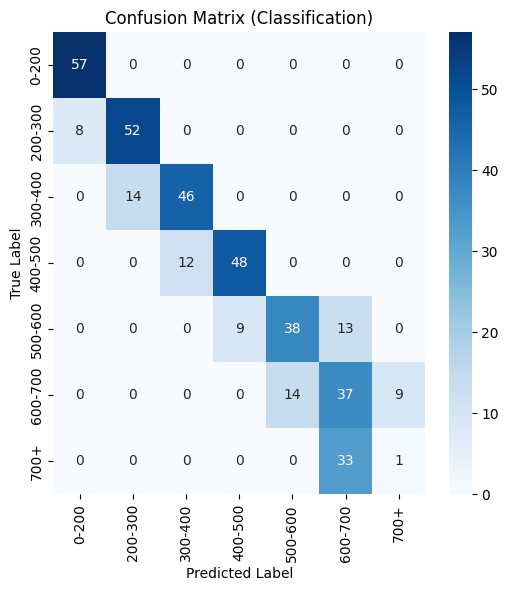

2025-03-05 13:38:37,979 - INFO - Classification Report:
              precision    recall  f1-score   support

       0-200       0.88      1.00      0.93        57
     200-300       0.79      0.87      0.83        60
     300-400       0.79      0.77      0.78        60
     400-500       0.84      0.80      0.82        60
     500-600       0.73      0.63      0.68        60
     600-700       0.45      0.62      0.52        60
        700+       0.10      0.03      0.05        34

    accuracy                           0.71       391
   macro avg       0.65      0.67      0.66       391
weighted avg       0.69      0.71      0.70       391



In [5]:
from src.evaluation import evaluate_classification_model

labels = ["0-200", "200-300", "300-400", "400-500", "500-600", "600-700", "700+"]

test_loss, test_accuracy, y_pred = evaluate_classification_model(cnn_model, X_test, y_test, labels=labels)